**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [49]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [50]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [51]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [52]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [53]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons
## The Perceptron

In [54]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [55]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [56]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

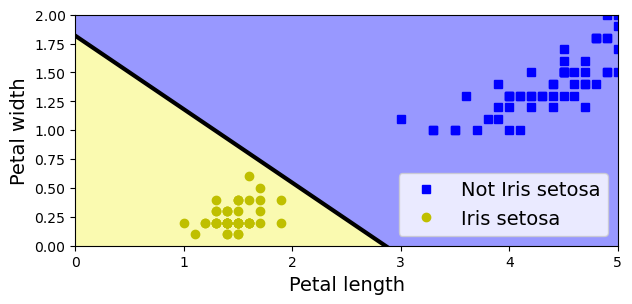

In [57]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

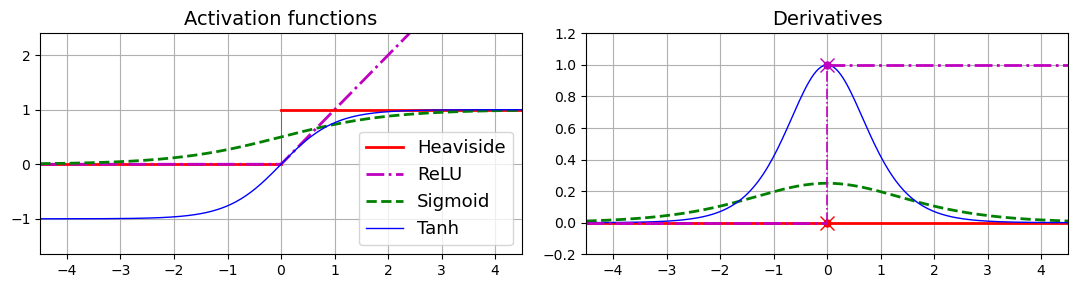

In [58]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

**Warning**: In recent versions of Scikit-Learn, you must use `root_mean_squared_error()` to compute the RMSE, instead of `mean_squared_error(labels, predictions, squared=False)`. The following `try`/`except` block tries to import `root_mean_squared_error`, and if it fails it just defines it.

In [59]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

In [60]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(
    #activation="relu", # uses the ReLU activation function by default
    #alpha=1.0,  <- controls l2 regularisation extent
    hidden_layer_sizes=[50, 50, 50],
    random_state=42
) # three hidden layers, composed of 50 neurons each.
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)

In [61]:
rmse

0.50533266579678

## Classification MLPs

In [62]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

mlp_classifier = MLPClassifier(
    hidden_layer_sizes=[10], # single hidden layer, 10 neurons
    random_state=42,
    max_iter=10_000 # number of steps for gradient descent to converge on the optimal values
)
pipeline_mlp_classifier = make_pipeline(
    StandardScaler(),
    mlp_classifier
)

pipeline_mlp_classifier.fit(X_train, y_train)

print(pipeline_mlp_classifier.score(X_train, y_train)) # accuracy train set
print(pipeline_mlp_classifier.score(X_test, y_test)) # accuracy test set

0.975
1.0


In [63]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [64]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [65]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [66]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [67]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

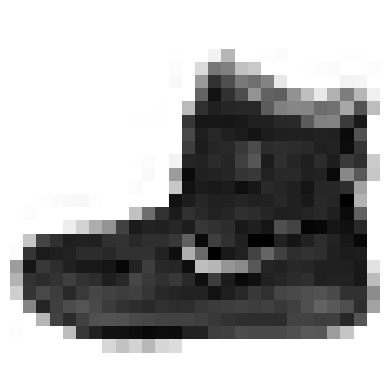

In [68]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [69]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

In [70]:
import pandas as pd

pd.DataFrame(y_train, columns=["class_id"])["class_id"].value_counts()

class_id
7    5550
6    5533
2    5510
1    5503
5    5497
3    5492
8    5485
0    5479
9    5478
4    5473
Name: count, dtype: int64

Here are the corresponding class names:

In [71]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# indexed lookup map

So the first image in the training set is an ankle boot:

In [72]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

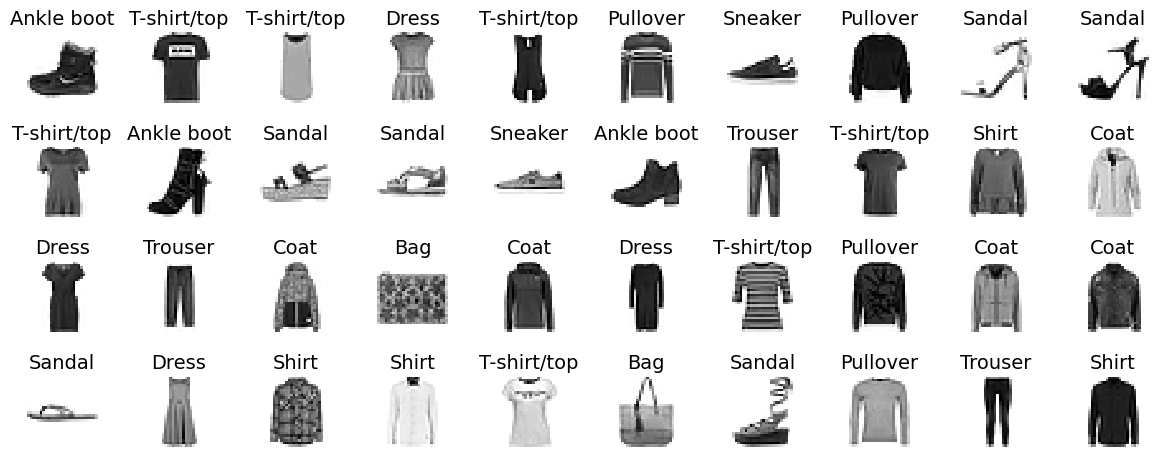

In [73]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

In [74]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Creating the model using the Sequential API

In [75]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu")) # Dense hidden layer #1 with 300 neurons. ReLU activation function.
model.add(tf.keras.layers.Dense(100, activation="relu")) # Dense hidden layer #2, with 100 neurons. Also using ReLU activation function
model.add(tf.keras.layers.Dense(10, activation="softmax")) # Dense output layer with 10 neurons. Uses softmax activation function because our clothing classes are exclusive.

In [76]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


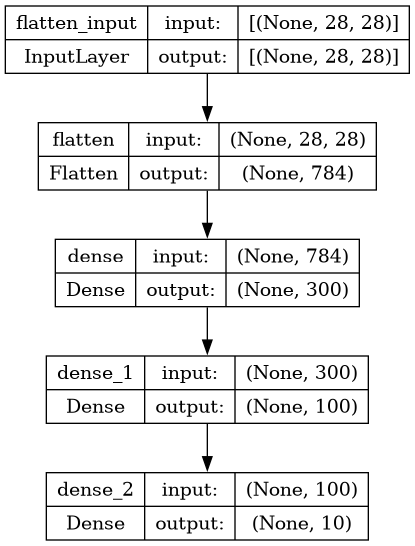

In [78]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [79]:
model.layers

In [80]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [81]:
model.get_layer('dense') is hidden1

True

In [82]:
weights, biases = hidden1.get_weights()
weights

array([[-5.36692291e-02,  2.46773660e-02, -5.85541129e-05, ...,
        -4.00690138e-02, -1.86517425e-02, -5.52710816e-02],
       [-2.50755250e-02,  7.42042512e-02, -3.27062085e-02, ...,
        -3.15524861e-02, -4.90481257e-02, -2.56066136e-02],
       [ 1.72631145e-02, -4.85876203e-02,  4.93531674e-02, ...,
        -7.09498376e-02, -1.99274309e-02, -6.13403022e-02],
       ...,
       [-4.15350832e-02, -3.86036187e-02,  1.21987835e-02, ...,
         1.78084895e-02,  1.17851198e-02,  8.82857293e-03],
       [ 5.05527258e-02,  3.78251076e-03,  2.49672681e-03, ...,
        -5.25478572e-02,  1.11173615e-02, -3.28558609e-02],
       [ 6.11564666e-02, -2.92786211e-03, -4.74388786e-02, ...,
        -4.67073172e-02,  1.36363506e-03,  4.68781888e-02]], dtype=float32)

In [83]:
weights.shape

(784, 300)

In [84]:
biases # biasses were initialised to zeros, which is fine

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [85]:
biases.shape

(300,)

### Compiling the model

In [86]:
model.compile(
    loss="sparse_categorical_crossentropy",  # <- we use this because we have sparse labels (for each instance, there is just a target class index from 0 to 9 here) + the classes are exclusive
    optimizer="sgd", # <- stochastic gradient descent
    metrics=["accuracy"] # <- optional extra metrics we would like to compute while we compile the model.
)

This is equivalent to:

In [87]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [88]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [89]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Training and evaluating the model

In [90]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7149 - sparse_categorical_accuracy: 0.7671 - val_loss: 0.5036 - val_sparse_categorical_accuracy: 0.8288
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4855 - sparse_categorical_accuracy: 0.8317 - val_loss: 0.4589 - val_sparse_categorical_accuracy: 0.8356
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4409 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.4247 - val_sparse_categorical_accuracy: 0.8532
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4174 - sparse_categorical_accuracy: 0.8538 - val_loss: 0.3955 - val_sparse_categorical_accuracy: 0.8608
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3973 - sparse_categorical_accuracy: 0.8619 - val_loss: 0.3936 - val_sparse_categorical_accuracy: 0.8612
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3812 - spars

In [91]:
history.params  # the training parameters

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [92]:
print(history.epoch) # the list of epochs it went through

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [93]:
history.history.keys() #  we can use these in a pd.DataFrame() to plot the progress over time!

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

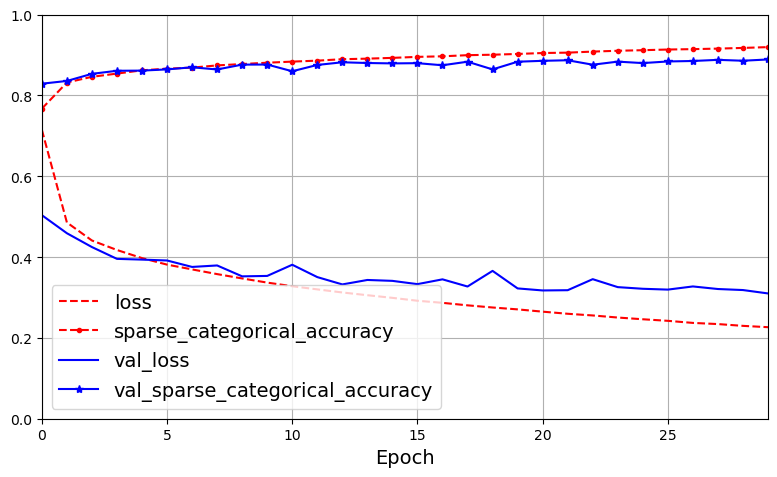

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

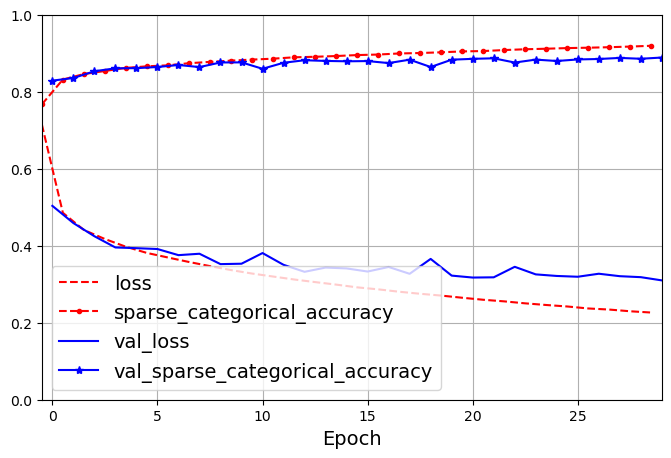

In [95]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [96]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3226 - sparse_categorical_accuracy: 0.8831


[0.3226405680179596, 0.8830999732017517]

### Using the model to make predictions

In [97]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 35ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [98]:
y_test[:3]

array([9, 2, 1], dtype=uint8)

In [99]:
np.array(class_names)[y_test[:3]]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [100]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [101]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [102]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

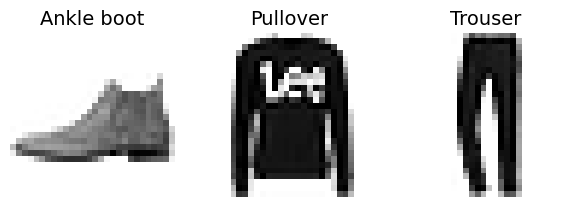

In [103]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [104]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [105]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
# this is kind of like StandardScaler(), however this one must be fitted to the triaining data before we call the model's .fit() method
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


2025-08-16 20:38:31.372252: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


363/363 [==============================] - 2s 4ms/step - loss: 0.9029 - root_mean_squared_error: 0.9502 - val_loss: 0.4287 - val_root_mean_squared_error: 0.6548
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3844 - root_mean_squared_error: 0.6200 - val_loss: 0.9602 - val_root_mean_squared_error: 0.9799
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3613 - root_mean_squared_error: 0.6011 - val_loss: 0.3920 - val_root_mean_squared_error: 0.6261
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3459 - root_mean_squared_error: 0.5881 - val_loss: 0.5544 - val_root_mean_squared_error: 0.7446
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3324 - root_mean_squared_error: 0.5765 - val_loss: 0.3474 - val_root_mean_squared_error: 0.5894
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3232 - root_mean_squared_error: 0.5685 - val_loss: 0.3542 - val_root_mean_s

In [106]:
# The Normalization layer learns the feature means + the standard deviation in the training data when you call the adapt() method.
# Yet when you display the model's summary, these statistics are listed as non-trainable.
#
#    => This is because these parameters are not affected by gradient descent!
#
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 8)                 17        
 on)                                                             
                                                                 
 dense_3 (Dense)             (None, 50)                450       
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5618 (21.95 KB)
Trainable params: 5601 (21.88 KB)
Non-trainable params: 17 (72.00 Byte)
__________________

In [107]:
rmse_test

0.5313053131103516

In [108]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

In [109]:
y_pred

array([[0.40716818],
       [0.9133552 ],
       [4.9532084 ]], dtype=float32)

## Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [110]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [111]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [112]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [113]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train) # <- we have to adapt it before it works, like calling .fit() on StandardScaler() in sci-kit learn! (see above)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.0385 - root_mean_squared_error: 1.0191 - val_loss: 1.8891 - val_root_mean_squared_error: 1.3744
Epoch 2/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4871 - root_mean_squared_error: 0.6979 - val_loss: 1.3913 - val_root_mean_squared_error: 1.1795
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4222 - root_mean_squared_error: 0.6498 - val_loss: 0.4906 - val_root_mean_squared_error: 0.7005
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3853 - root_mean_squared_error: 0.6207 - val_loss: 0.5323 - val_root_mean_squared_error: 0.7296
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3743 - root_mean_squared_error: 0.6118 - val_loss: 2.1800 - val_root_mean_squared_error: 1.4765
Epoch 6/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3761 - root_mean_squared_error: 0.6133 - val_loss: 3.9643 - val_

In [114]:
mse_test

[0.316061407327652, 0.5621933937072754]

In [115]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

In [116]:
y_pred

array([[0.38723832],
       [1.1873395 ],
       [4.5022125 ]], dtype=float32)

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [117]:
tf.random.set_seed(42)  # extra code

In [118]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [119]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), # We call fit() as usual, however because we specified two split inputs, we have to pass the data for those inputs separately like this (see [input_wide, input_deep] above)
    y_train,
    epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), # <- same here!
    y_valid)
)
mse_test = model.evaluate(
    (X_test_wide, X_test_deep), # <- same here!
    y_test
)
y_pred = model.predict(
    (X_new_wide, X_new_deep) # <- same here!
)

# NOTE: per the book we could also pass a dictionary instead of a tuple {"input_wide": X_train_wide, "input_deep": X_train_deep}
# but we would need to set the names when creating the inputs in this case (above)

Epoch 1/20
363/363 [==============================] - 2s 4ms/step - loss: 1.5627 - root_mean_squared_error: 1.2501 - val_loss: 0.8460 - val_root_mean_squared_error: 0.9198
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.5888 - root_mean_squared_error: 0.7673 - val_loss: 1.4379 - val_root_mean_squared_error: 1.1991
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4765 - root_mean_squared_error: 0.6903 - val_loss: 0.4120 - val_root_mean_squared_error: 0.6419
Epoch 4/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4213 - root_mean_squared_error: 0.6491 - val_loss: 0.5338 - val_root_mean_squared_error: 0.7306
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.3926 - root_mean_squared_error: 0.6266 - val_loss: 0.3657 - val_root_mean_squared_error: 0.6047
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.3746 - root_mean_squared_error: 0.6120 - val_loss: 0.3586 - val_

Adding an auxiliary output for regularization:

In [120]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [121]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2) # <- extra output layer!
model = tf.keras.Model(
    inputs=[input_wide, input_deep],
    outputs=[output, aux_output]  # <- we also need to add it here!
)

In [122]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 normalization_1 (Normaliza  (None, 6)                    13        ['input_2[0][0]']             
 tion)                                                                                            
                                                                                                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 30)                   210       ['normalization_1[0][0]'] 

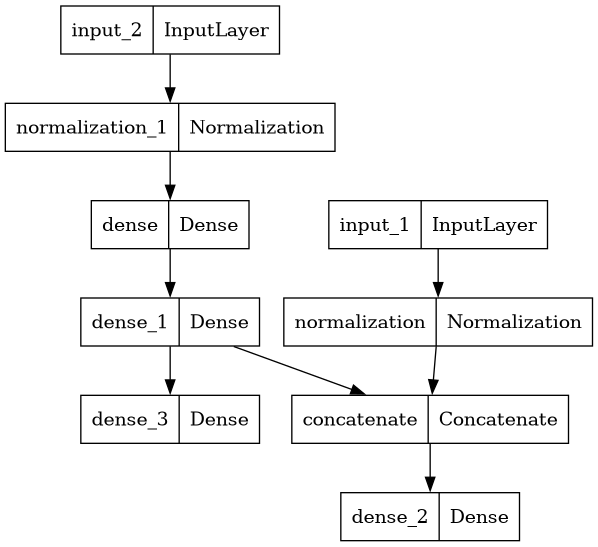

In [123]:
tf.keras.utils.plot_model(model)

**Warning**: in recent versions, Keras requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [124]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    loss=("mse", "mse"), # <- each output layer needs its own loss function (the thing it's going to try to optimize/minimise during gradient descent)
    loss_weights=(0.9, 0.1), # <- since we care much more about the main ouptut over the auxiliary output, we give a weight of 0.9 to the main output and only 0.1 to the aux one
    optimizer=optimizer,
    metrics=["RootMeanSquaredError"] #, "RootMeanSquaredError"]
)

# NOTE: we could have yet again used a dictionary here to pass these values per output if we declared the outputs with names too. Better IRL.

In [125]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20, # here we pass the (y_train, y_train) because we need to match the labels for both outputs. We could've used a named dict here too (preferred)
    validation_data=(
        (X_valid_wide, X_valid_deep), (y_valid, y_valid) # ^ same thing here with the y_valid, y_valid.
    )
)

Epoch 1/20
363/363 [==============================] - 5s 12ms/step - loss: 1.8184 - dense_2_loss: 1.7664 - dense_3_loss: 2.2863 - dense_2_root_mean_squared_error: 1.3291 - dense_3_root_mean_squared_error: 1.5121 - val_loss: 1.6061 - val_dense_2_loss: 1.2640 - val_dense_3_loss: 4.6850 - val_dense_2_root_mean_squared_error: 1.1243 - val_dense_3_root_mean_squared_error: 2.1645
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.6792 - dense_2_loss: 0.6634 - dense_3_loss: 0.8210 - dense_2_root_mean_squared_error: 0.8145 - dense_3_root_mean_squared_error: 0.9061 - val_loss: 1.8678 - val_dense_2_loss: 1.5773 - val_dense_3_loss: 4.4830 - val_dense_2_root_mean_squared_error: 1.2559 - val_dense_3_root_mean_squared_error: 2.1173
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.5600 - dense_2_loss: 0.5498 - dense_3_loss: 0.6527 - dense_2_root_mean_squared_error: 0.7415 - dense_3_root_mean_squared_error: 0.8079 - val_loss: 0.6668 - val_dense_2_los

**Warning**: in recent TF version, `evaluate()` also returns the main metric and the aux metric. To ensure the code works in both old and new versions, we only look at the first 3 elements of `eval_results` (i.e., just the losses):

In [126]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test)) # optionally: `return_dict=True` to get this as a dict!
weighted_sum_of_losses, main_loss, aux_loss = eval_results[:3]

162/162 [==============================] - 0s 3ms/step - loss: 0.3398 - dense_2_loss: 0.3333 - dense_3_loss: 0.3984 - dense_2_root_mean_squared_error: 0.5773 - dense_3_root_mean_squared_error: 0.6312


In [127]:
eval_results

[0.33981868624687195,
 0.3333139717578888,
 0.39836183190345764,
 0.5773335099220276,
 0.6311591267585754]

In [128]:
weighted_sum_of_losses

0.33981868624687195

In [129]:
main_loss

0.3333139717578888

In [130]:
aux_loss

0.39836183190345764

In [131]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep)) # similarly for two-output here.

1/1 [==============================] - 0s 34ms/step


In [132]:
y_pred_main

array([[0.24618505],
       [1.131598  ],
       [3.5414274 ]], dtype=float32)

In [133]:
y_pred_aux

array([[0.5159849 ],
       [0.92092246],
       [3.231021  ]], dtype=float32)

How to get a dictionary from `.predict()` even though it doesn't support `return_dict=True`?

In [134]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 11ms/step


In [135]:
y_pred

{'dense_2': array([[0.24618505],
        [1.131598  ],
        [3.5414274 ]], dtype=float32),
 'dense_3': array([[0.5159849 ],
        [0.92092246],
        [3.231021  ]], dtype=float32)}

## Using the Subclassing API to Build Dynamic Models

In [136]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

**Warning**: as explained above, Keras now requires one loss and one metric per output, so I replaced `loss="mse"` with `loss=["mse", "mse"]` and I also replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [137]:
# basically the model works the same as usual
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    loss=["mse", "mse"],
    loss_weights=[0.9, 0.1],
    optimizer=optimizer,
    metrics=["RootMeanSquaredError"]
)
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=10,
    validation_data=(
        (X_valid_wide, X_valid_deep), (y_valid, y_valid)
    )
)
eval_results = model.evaluate(
    (X_test_wide, X_test_deep),
    (y_test, y_test)
)
y_pred_main, y_pred_aux = model.predict(
    (X_new_wide, X_new_deep)
)

Epoch 1/10
363/363 [==============================] - 3s 7ms/step - loss: 1.8302 - output_1_loss: 1.8285 - output_2_loss: 1.8457 - output_1_root_mean_squared_error: 1.3522 - output_2_root_mean_squared_error: 1.3586 - val_loss: 1.3306 - val_output_1_loss: 0.7189 - val_output_2_loss: 6.8356 - val_output_1_root_mean_squared_error: 0.8479 - val_output_2_root_mean_squared_error: 2.6145
Epoch 2/10
363/363 [==============================] - 2s 6ms/step - loss: 0.6008 - output_1_loss: 0.5880 - output_2_loss: 0.7161 - output_1_root_mean_squared_error: 0.7668 - output_2_root_mean_squared_error: 0.8462 - val_loss: 1.1966 - val_output_1_loss: 1.0035 - val_output_2_loss: 2.9347 - val_output_1_root_mean_squared_error: 1.0017 - val_output_2_root_mean_squared_error: 1.7131
Epoch 3/10
363/363 [==============================] - 2s 6ms/step - loss: 0.5113 - output_1_loss: 0.5006 - output_2_loss: 0.6078 - output_1_root_mean_squared_error: 0.7075 - output_2_root_mean_squared_error: 0.7796 - val_loss: 0.570

In [138]:
model.summary()

Model: "my_cool_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  multiple                  11        
 tion)                                                           
                                                                 
 normalization_3 (Normaliza  multiple                  13        
 tion)                                                           
                                                                 
 dense_4 (Dense)             multiple                  210       
                                                                 
 dense_5 (Dense)             multiple                  930       
                                                                 
 dense_6 (Dense)             multiple                  36        
                                                                 
 dense_7 (Dense)             multiple                

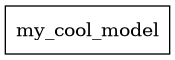

In [139]:
tf.keras.utils.plot_model(model) # except it's not interpretable :(

# so the subclassing technique is good for research/experimentation but not for production type models necessarily.

## Saving and Restoring a Model

**Warning**: Keras now recommends using the `.keras` format to save models, and the `h5` format for weights. Therefore I have updated the code in this section to first show what you need to change if you still want to use TensorFlow's `SavedModel` format, and then how you can use the recommended formats.

In [140]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

**Warning**: Keras's `model.save()` method no longer supports TensorFlow's `SavedModel` format. However, you can still export models to the `SavedModel` format using `model.export()` like this:

In [141]:
model.export("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: (<1>, <2>)
      <1>: float32 Tensor, shape=(None, 5)
      <2>: float32 Tensor, shape=(None, 6)
  Returns:
    (<1>, <2>)
      <1>: float32 Tensor, shape=(None, 1)
      <2>: float32 Tensor, shape=(None, 1)


In [142]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


**Warning**: In Keras 3, it is no longer possible to load a TensorFlow `SavedModel` as a Keras model. However, you can load a `SavedModel` as a `tf.keras.layers.TFSMLayer` layer, but be aware that this layer can only be used for inference: no training.

In [145]:
tfsm_layer = tf.keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'TFSMLayer'

**Warning**: Keras now requires the saved weights to have the `.weights.h5` extension. There are no longer saved using the `SavedModel` format.

In [150]:
model.save_weights("my_weights.weights.h5")

In [151]:
model.load_weights("my_weights.weights.h5")

To save a model using the `.keras` format, simply use `model.save()`:

In [152]:
model.save("my_model.keras")

To load a `.keras` model, use the `tf.keras.models.load_model()` function. If the model uses any custom object, you must pass them to the function via the `custom_objects` argument:

In [153]:
loaded_model = tf.keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)

## Using Callbacks

In [154]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

**Warning**: as explained earlier, Keras now requires the checkpoint files to have a `.weights.h5` extension:

In [155]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints.weights.h5",
    save_weights_only=True
)

history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb] # <- how to define a callback to call @ the end of each epoch
)

# SO tl;dr this will save the model's weights at the end of each epoch. Which is useful to prevent data loss in case we crash during training and want to resume from the last state.

Epoch 1/10
363/363 [==============================] - 2s 6ms/step - loss: 0.3573 - output_1_loss: 0.3505 - output_2_loss: 0.4183 - output_1_root_mean_squared_error: 0.5920 - output_2_root_mean_squared_error: 0.6467 - val_loss: 0.4889 - val_output_1_loss: 0.4914 - val_output_2_loss: 0.4668 - val_output_1_root_mean_squared_error: 0.7010 - val_output_2_root_mean_squared_error: 0.6833
Epoch 2/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3486 - output_1_loss: 0.3414 - output_2_loss: 0.4135 - output_1_root_mean_squared_error: 0.5843 - output_2_root_mean_squared_error: 0.6430 - val_loss: 0.7286 - val_output_1_loss: 0.7392 - val_output_2_loss: 0.6334 - val_output_1_root_mean_squared_error: 0.8598 - val_output_2_root_mean_squared_error: 0.7959
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 0.3502 - output_1_loss: 0.3437 - output_2_loss: 0.4089 - output_1_root_mean_squared_error: 0.5862 - output_2_root_mean_squared_error: 0.6394 - val_loss: 0.401

In [156]:
# this thing will interrupt training when it measures no progress on the validation set for a number of epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, # <- the number of epochs
    restore_best_weights=True # <- if we set this, it will roll back to the best model at the end of training
)

history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train),
    epochs=100,
    validation_data=(
        (X_valid_wide, X_valid_deep), (y_valid, y_valid)
    ),
    callbacks=[checkpoint_cb, early_stopping_cb] # <- here's how we ensure we both save checkpoints of the weights @ every epoch & implement early stopping for when we notice no improvement on the loss fn after 10 epochs
)

Epoch 1/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3359 - output_1_loss: 0.3299 - output_2_loss: 0.3900 - output_1_root_mean_squared_error: 0.5743 - output_2_root_mean_squared_error: 0.6245 - val_loss: 0.4149 - val_output_1_loss: 0.4157 - val_output_2_loss: 0.4083 - val_output_1_root_mean_squared_error: 0.6447 - val_output_2_root_mean_squared_error: 0.6390
Epoch 2/100
363/363 [==============================] - 2s 5ms/step - loss: 0.3333 - output_1_loss: 0.3273 - output_2_loss: 0.3875 - output_1_root_mean_squared_error: 0.5721 - output_2_root_mean_squared_error: 0.6225 - val_loss: 0.4118 - val_output_1_loss: 0.3820 - val_output_2_loss: 0.6805 - val_output_1_root_mean_squared_error: 0.6180 - val_output_2_root_mean_squared_error: 0.8250
Epoch 3/100
363/363 [==============================] - 2s 6ms/step - loss: 0.3323 - output_1_loss: 0.3264 - output_2_loss: 0.3854 - output_1_root_mean_squared_error: 0.5713 - output_2_root_mean_squared_error: 0.6208 - val_loss: 0.

In [157]:
# for when you want to implement your own custom callback!
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [158]:
val_train_ratio_cb = PrintValTrainRatioCallback() # instantiate custom callback

history = model.fit(
    (X_train_wide, X_train_deep),
    (y_train, y_train), epochs=10,
    validation_data=(
        (X_valid_wide, X_valid_deep), (y_valid, y_valid)
    ),
    callbacks=[val_train_ratio_cb],  # <- this is how we use our custom callback!
    verbose=0
)

Epoch=0, val/train=3.27
Epoch=1, val/train=4.23
Epoch=2, val/train=1.05
Epoch=3, val/train=1.04
Epoch=4, val/train=1.22
Epoch=5, val/train=1.87
Epoch=6, val/train=1.32
Epoch=7, val/train=2.23
Epoch=8, val/train=1.66
Epoch=9, val/train=2.18


## Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [ ]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [159]:
import shutil

shutil.rmtree("my_logs", ignore_errors=True)

In [160]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [174]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(
    learning_rate=2e-3#1e-3
)

model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [175]:
# this will initialise the directory if needed (including parents)
# and will create event files and write summaries to them during training.
# it will measure the model's training + validation loss and metrics
# + it will also profile your neural network.
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    run_logdir,
    profile_batch=(100, 200)
)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[tensorboard_cb]
)

Epoch 1/20


2025-08-16 20:58:09.210291: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-08-16 20:58:09.210327: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-08-16 20:58:09.210349: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-08-16 20:58:09.210354: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-08-16 20:58:09.210356: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2025-08-16 20:58:09.210359: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1746] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2025-08-16 20:58:09.210822: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session te

140/363 [==========>...................] - ETA: 0s - loss: 2.0575 - root_mean_squared_error: 1.4344

2025-08-16 20:58:09.865353: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-08-16 20:58:09.865389: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-08-16 20:58:09.865402: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-08-16 20:58:09.865405: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-08-16 20:58:09.865407: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2025-08-16 20:58:09.865409: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1746] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 


228/363 [=================>............] - ETA: 0s - loss: 1.7191 - root_mean_squared_error: 1.3111

2025-08-16 20:58:10.264239: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2025-08-16 20:58:10.270086: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:142] cuptiFinalize: ignored due to a previous error.
2025-08-16 20:58:10.270123: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2025-08-16 20:58:10.270127: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1837] function cupti_interface_->Finalize()failed with error 
2025-08-16 20:58:10.291568: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-08-16 20:58:10.291611: E tensorflow/compiler/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-08-16 20:58:10.291617: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTra

363/363 [==============================] - 2s 5ms/step - loss: 1.3329 - root_mean_squared_error: 1.1545 - val_loss: 4.8310 - val_root_mean_squared_error: 2.1980
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.6261 - root_mean_squared_error: 0.7913 - val_loss: 0.5043 - val_root_mean_squared_error: 0.7101
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5008 - root_mean_squared_error: 0.7077 - val_loss: 0.4460 - val_root_mean_squared_error: 0.6678
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4584 - root_mean_squared_error: 0.6770 - val_loss: 0.4486 - val_root_mean_squared_error: 0.6698
Epoch 5/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4373 - root_mean_squared_error: 0.6613 - val_loss: 0.4487 - val_root_mean_squared_error: 0.6699
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4243 - root_mean_squared_error: 0.6514 - val_loss: 0.4678 - val_root_mean_s

In [165]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2025_08_16_20_47_41
    plugins
      profile
        2025_08_16_20_48_04
          shane.xplane.pb
    train
      events.out.tfevents.1755370083.shane.34920.2.v2
    validation
      events.out.tfevents.1755370085.shane.34920.3.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [167]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [176]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [177]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)

        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)

        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)

        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)

        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**Note**: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [178]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:25:01 ago; pid 47450)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [179]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [180]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [95]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [181]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [182]:
random_search_tuner = kt.RandomSearch( # same idea as RandomSearchCV
    build_model, # <- use our build callback function
    objective="val_accuracy",
    max_trials=5, # <- run 5 trials
    directory="my_fashion_mnist", # <- save it to this directory
    project_name="my_rnd_search", # <- ^ @ `my_fashion_mnist/my_rnd_search`
    overwrite=True, # <- will overwrite the `my_fashion_mnist/my_rnd_search` directory if it already exists
    seed=42
)
# if you were to turn off the `overwrite` and set `max_trials=10`, the tuner would actually just continue tuning where it left off, running 5 more trials.
# this means you don't have to run all the trials in one shot.

random_search_tuner.search( # <- perform the search by .fit()-ting to these params
    X_train,
    y_train,
    epochs=10, # <- train it for 10 epochs
    validation_data=(X_valid, y_valid)
)

Trial 5 Complete [00h 01m 08s]
val_accuracy: 0.8349999785423279

Best val_accuracy So Far: 0.8604000210762024
Total elapsed time: 00h 05m 49s


In [183]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [186]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [187]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8604000210762024


In [188]:
best_trial.metrics.get_last_value("val_accuracy")

0.8604000210762024

In [ ]:
# Once we've found a model we're happy with through searching
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.3367 - accuracy: 0.8767
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3282 - accuracy: 0.8799
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3180 - accuracy: 0.8837
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3100 - accuracy: 0.8867
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3042 - accuracy: 0.8880
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2957 - accuracy: 0.8921
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2891 - accuracy: 0.8929
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2831 - accuracy: 0.8950
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2777 - accuracy: 0.8978
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.4161 

In [191]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        # if we want to be able to control whether or not we normalise the data before training the model, we can do something like this
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [192]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(),
    objective="val_accuracy",
    seed=42,
    max_epochs=10,
    factor=3,
    hyperband_iterations=2,
    overwrite=True,
    directory="my_fashion_mnist",
    project_name="hyperband"
)

In [193]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb, tensorboard_cb]
)

Trial 60 Complete [00h 01m 15s]
val_accuracy: 0.8503999710083008

Best val_accuracy So Far: 0.8759999871253967
Total elapsed time: 00h 30m 02s


In [194]:
# "smarter" search. still explores the hyperparameter space randomly.
# gradually learns which regions of the hyperparameter space are most
# promising by fitting a probabilistic model called a Gaussian process,
# allowing it to gradually zoom in on the best hyperparameters.
# downside being that it has its own hyperparameters (alpha, beta)

bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(),
    objective="val_accuracy",
    seed=42,
    max_trials=10,
    alpha=1e-4,
    beta=2.6,
    overwrite=True,
    directory="my_fashion_mnist",
    project_name="bayesian_opt"
)

bayesian_opt_tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_cb]
)

Trial 10 Complete [00h 01m 23s]
val_accuracy: 0.848800003528595

Best val_accuracy So Far: 0.8546000123023987
Total elapsed time: 00h 08m 48s


In [107]:
%tensorboard --logdir {root_logdir}

# Exercise solutions

## 1. to 9.

1. Visit the [TensorFlow Playground](https://playground.tensorflow.org/) and play around with it, as described in this exercise.

2. Here is a neural network based on the original artificial neurons that computes _A_ ⊕ _B_ (where ⊕ represents the exclusive OR), using the fact that _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). There are other solutions—for example, using the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), or the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_), and so on.<br /><img width="70%" src="images/ann/exercise2.png" />
3. A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.
4. The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.
5. Popular activation functions include the step function, the sigmoid function, the hyperbolic tangent (tanh) function, and the Rectified Linear Unit (ReLU) function (see Figure 10-8). See Chapter 11 for other examples, such as ELU and variants of the ReLU function.
6. Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:
    * The shape of the input matrix **X** is _m_ × 10, where _m_ represents the training batch size.
    * The shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10 × 50, and the length of its bias vector **b**<sub>_h_</sub> is 50.
    * The shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50 × 3, and the length of its bias vector **b**<sub>_o_</sub> is 3.
    * The shape of the network's output matrix **Y** is _m_ × 3.
    * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**<sub>_o_</sub> + **b**<sub>_o_</sub>). Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called _broadcasting_.
7. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. You would typically use the sigmoid activation function in the output layer when estimating a probability. If instead you want to tackle MNIST, you need 10 neurons in the output layer, and you must replace the sigmoid function with the softmax activation function, which can handle multiple classes, outputting one probability per class. If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log _v_) = _v_).
8. Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once (see Appendix B for more details). So what's the difference? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happens to be used by backpropagation.
9. Here is a list of all the hyperparameters you can tweak in a basic MLP: the number of hidden layers, the number of neurons in each hidden layer, and the activation function used in each hidden layer and in the output layer. In general, the ReLU activation function (or one of its variants; see Chapter 11) is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, you can try reducing the number of hidden layers and reducing the number of neurons per hidden layer.

## 10.

*Exercise: 
1. Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`.

2. See if you can get over 98% accuracy by manually tuning the hyperparameters. 
3. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). 
4. Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

**TODO**: update this solution to use Keras Tuner.

Let's load the dataset:

In [108]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [109]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [110]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [111]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

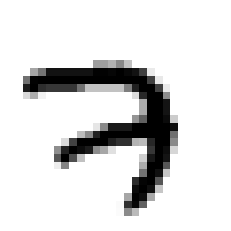

In [112]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [113]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [114]:
X_valid.shape

(5000, 28, 28)

In [115]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

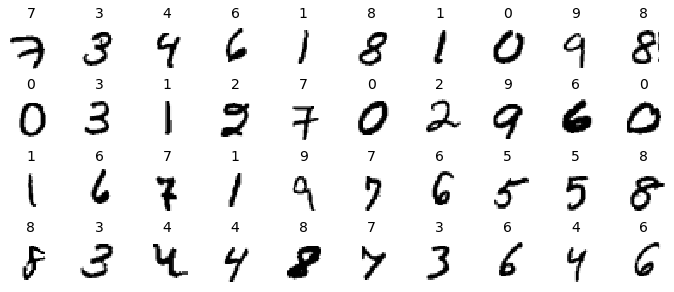

In [116]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [117]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [118]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [120]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [121]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.5843 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

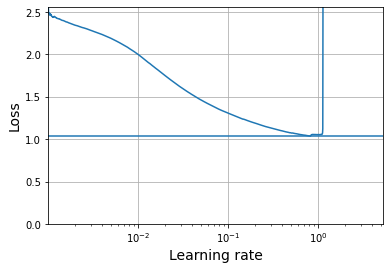

In [122]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [123]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [125]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [126]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [127]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2363 - accuracy: 0.9264 - val_loss: 0.0972 - val_accuracy: 0.9720
Epoch 2/100
1719/1719 [==============================] - 2s 997us/step - loss: 0.0948 - accuracy: 0.9702 - val_loss: 0.1035 - val_accuracy: 0.9706
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0667 - accuracy: 0.9792 - val_loss: 0.0783 - val_accuracy: 0.9770
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0463 - accuracy: 0.9848 - val_loss: 0.0827 - val_accuracy: 0.9766
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0359 - accuracy: 0.9881 - val_loss: 0.0698 - val_accuracy: 0.9826
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.1048 - val_accuracy: 0.9758
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.0932 - val_

In [128]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 908us/step - loss: 0.0708 - accuracy: 0.9799


[0.07079131156206131, 0.9799000024795532]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [129]:
%tensorboard --logdir=./my_mnist_logs